In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import geopy.distance
import geopy.point
import math
 
R = 6373.0

pd.set_option("display.max_column", 999)
#print(os.listdir("../input"))

# Load the data!

In [2]:
tourney_results = pd.read_csv('MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('MDataFiles_Stage1/MNCAATourneySeeds.csv')
regular_results = pd.read_csv('MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
compact_regular_results = pd.read_csv('MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
game_cities = pd.read_csv('MDataFiles_Stage1/MGameCities.csv')
city_names = pd.read_csv('MDataFiles_Stage1/Cities.csv')
team_names = pd.read_csv('MDataFiles_Stage1/MTeams.csv')
box_score_features = pd.read_csv('box_score_features.csv')

In [3]:
lat_long_df = pd.read_csv('uscities.csv')

In [4]:
Massey = pd.read_csv('MDataFiles_Stage1/MMasseyOrdinals.csv')

### Preparation

In [5]:
city_names = city_names.replace('Mt. Pleasant', 'Mount Pleasant')

## Get location data for each team

In [6]:
location_data = pd.merge(compact_regular_results[(compact_regular_results['Season']>2009)],game_cities[game_cities['CRType'] == 'Regular'], on=['Season','DayNum','WTeamID','LTeamID'])
location_data = location_data[location_data['WLoc'] == 'H'].drop_duplicates(subset = ['WTeamID','CityID'], keep = 'last').drop(['DayNum', 'LTeamID','LTeamID','Season','LScore','WScore','WLoc','CRType','NumOT'],axis = 1)
location_data = pd.merge(pd.merge(location_data,city_names, on = 'CityID'),team_names, left_on = 'WTeamID',right_on = 'TeamID').drop(['FirstD1Season','WTeamID','LastD1Season'], axis = 1)
location_data = location_data[['TeamID','TeamName','CityID','City','State']]

lat_long_df = lat_long_df[['city','state_id','lat','lng']]
lat_long_df['lng'] = -lat_long_df['lng']
location_data = pd.merge(location_data, lat_long_df, left_on = ['City','State'], right_on = ['city','state_id'], how = 'left')
location_data.drop(['city','state_id'], axis = 1, inplace = True)

location_data = location_data.append([{'TeamID':0,'TeamName':'none','CityID':4008,'City':'Anaheim','State':'CA','lat':33.839,'lng':117.8573}], ignore_index = True)

In [7]:
location_data.at[25, 'lat']  = 41.2214 
location_data.at[25, 'lng']  = 73.2419
location_data.at[63, 'lat']  = 42.0841
location_data.at[63, 'lng']  = 76.0542
location_data.at[85, 'lat']  = 40.8940
location_data.at[85, 'lng']  = 73.9109
location_data.at[92, 'lat']  = 41.7082
location_data.at[92, 'lng']  = 73.9239
location_data.at[148, 'lat']  = 38.9983
location_data.at[148, 'lng']  = 104.8613
location_data.at[153, 'lat']  = 41.9221
location_data.at[153, 'lng']  = 71.5496
location_data.at[211, 'lat']  = 42.3233
location_data.at[211, 'lng']  = 71.1423
location_data.at[215, 'lat']  = 34.2379
location_data.at[215, 'lng']  = 118.5301
location_data.at[288, 'lat']  = 43.1398
location_data.at[288, 'lng']  = 70.9226
location_data.at[331, 'lat']  = 41.7620
location_data.at[331, 'lng']  = 72.7420
location_data.at[362, 'lat']  = 40.8121
location_data.at[362, 'lng']  = 77.8561

In [8]:
location_data = location_data.dropna()

In [9]:
pd.set_option('display.max_rows',380)
location_data 

,TeamID,TeamName,CityID,City,State,lat,lng
0,1445,W Salem St,4371,Winston-Salem,NC,36.1029,80.2610
1,1448,Wake Forest,4371,Winston-Salem,NC,36.1029,80.2610
2,1147,Centenary,4315,Shreveport,LA,32.4659,93.7959
3,1210,Georgia Tech,4100,Duluth,GA,34.0053,84.1491
4,1210,Georgia Tech,4016,Atlanta,GA,33.7627,84.4225
6,1263,Maine,4023,Bangor,ME,44.8322,68.7906
7,1374,SMU,4129,Garland,TX,32.9100,96.6305
8,1374,SMU,4088,Dallas,TX,32.7936,96.7662
9,1155,Clemson,4139,Greenville,SC,34.8362,82.3649
10,1155,Clemson,4074,Clemson,SC,34.6838,82.8124


## Get most out of Massey Ordinals

Only valid System Names are the ones, which were active 2003 through 2019

In [10]:
valid_2003_system_names = ['COL','DOL','MOR','POM','RTH','SAG','WLK','WOL']

In [11]:
valid_massey = Massey[Massey['SystemName'].isin(valid_2003_system_names)]
valid_massey = valid_massey[valid_massey['RankingDayNum'] == 133].sort_values(by=['SystemName','Season','TeamID']).reset_index(drop = True)

MasRating = valid_massey[valid_massey['SystemName'] == 'COL'].drop(['SystemName','RankingDayNum'], axis = 1).rename(columns={'OrdinalRank':'COL'})
for x in valid_2003_system_names[1:]:
    MasRating = pd.merge(MasRating, valid_massey[valid_massey['SystemName'] == x].drop(['SystemName','RankingDayNum'], axis = 1).rename(columns={'OrdinalRank': x}), on = ['Season','TeamID'])

In [12]:
MasRating

,Season,TeamID,COL,DOL,MOR,POM,RTH,SAG,WLK,WOL
0,2003,1102,162,175,132,160,146,149,165,157
1,2003,1103,172,174,139,163,168,172,172,171
2,2003,1104,43,39,26,33,31,37,36,37
3,2003,1105,310,315,309,307,312,312,310,311
4,2003,1106,256,266,294,263,274,268,254,270
...,...,...,...,...,...,...,...,...,...,...
5823,2019,1462,66,67,70,64,54,57,62,72
5824,2019,1463,61,75,94,82,97,94,76,59
5825,2019,1464,286,263,276,263,266,275,275,271
5826,2019,1465,212,211,258,192,213,242,209,205


##### Turn on this cell to create margins

In [13]:
for x in valid_2003_system_names:
    MasRating['n'+x]  = 100 - 4*np.log(MasRating[x]+1) - MasRating[x]/22
    MasRating = MasRating.drop(x,axis = 1)
    MasRating.rename(columns={'n' + x:x}, inplace=True)

In [14]:
MasRating

,Season,TeamID,COL,DOL,MOR,POM,RTH,SAG,WLK,WOL
0,2003,1102,72.261363,71.363519,74.438603,72.401655,73.401906,73.184732,72.052049,72.613256
1,2003,1103,71.568652,71.431765,73.915248,72.191443,71.844042,71.568652,71.568652,71.637295
2,2003,1104,82.908696,83.471755,85.634834,84.394558,84.727965,83.767837,83.919965,83.767837
3,2003,1105,62.949919,62.658849,63.008256,63.125055,62.833369,62.833369,62.949919,62.891624
4,2003,1106,66.167332,65.560096,63.888462,65.741658,65.078370,65.439336,66.289491,65.318797
...,...,...,...,...,...,...,...,...,...,...
5823,2019,1462,80.181230,80.076515,79.767462,80.393360,81.516122,81.167319,80.609279,79.565435
5824,2019,1463,80.718735,79.267976,77.511765,78.597365,77.251039,77.511765,79.170233,80.940804
5825,2019,1464,64.362071,65.741658,64.958475,65.741658,65.560096,65.018397,65.018397,65.258610
5826,2019,1465,68.918468,68.982746,66.045415,70.221967,68.854278,67.027754,69.111570,69.370314


In [15]:
tourney_results.shape

(1115, 34)

In [16]:
seeds.shape

(2286, 3)

In [17]:
regular_results.shape

(87504, 34)

In [18]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [19]:
regular_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,16.500650,23.250217,11.580589,25.143847,15.278380,14.211872,7.622184,3.756282,17.880633,22.869584,56.866118,5.824090,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,16.405601,23.286371,11.608182,25.049880,15.137169,14.049880,7.742070,3.639029,17.798075,22.569241,56.301247,5.826515,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,15.973476,22.787594,11.565775,24.964920,15.184385,13.907380,7.699251,3.730053,17.403850,22.427594,56.047914,5.904385,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,15.901198,22.458272,11.591760,24.641581,15.141896,13.893000,7.616985,3.708430,17.253731,22.456801,55.836872,5.945133,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,15.992465,22.698989,11.222487,24.756098,15.043030,13.909974,7.179853,3.735277,17.443783,22.419790,55.712274,6.059092,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,15.934922,22.575828,11.133256,25.101491,14.921557,13.720705,7.300213,3.777455,17.450126,22.392408,55.829556,6.165408,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,15.836350,22.485616,11.178129,25.155839,14.568108,13.223852,7.161174,3.723757,17.297390,22.168223,55.771004,5.759954,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,0.063272,25.799734,54.756603,6.655330,17.520616,16.397682,23.306289,11.247767,25.550447,14.509215,13.117234,7.100513,3.989550,17.484515,22.180885,56.121414,5.690291,18.618659,12.432263,18.563177,11.568687,21.415162,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,0.077964,25.600839,54.468547,6.733321,17.675562,16.439192,23.221883,11.132863,25.473504,14.476363,12.904117,6.787266,3.829966,17.581395,22.159360,55.676325,5.736561,18.551658,12.415364,18.471979,11.168319,21.326916,11.180518,14.131910,5.933283,2.961685,20.081395


In [20]:
tourney_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,14.515625,20.218750,11.781250,25.546875,14.765625,12.875000,7.015625,3.890625,17.453125,23.375000,58.906250,6.515625,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,16.812500,23.296875,11.125000,25.875000,14.859375,12.546875,6.921875,3.625000,16.625000,23.140625,58.468750,6.203125,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,16.046875,22.203125,10.609375,25.203125,15.093750,13.078125,7.031250,3.484375,17.000000,23.531250,58.546875,6.328125,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,16.625000,22.640625,11.109375,24.718750,14.125000,11.906250,6.718750,4.250000,15.562500,22.984375,57.234375,6.171875,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,17.250000,23.531250,11.531250,25.500000,13.921875,12.265625,6.156250,4.015625,16.796875,22.937500,57.390625,6.046875,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,15.281250,21.265625,11.312500,26.546875,15.218750,12.718750,6.515625,4.062500,17.468750,22.375000,57.390625,6.250000,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,16.671875,23.000000,11.812500,26.531250,15.546875,12.250000,6.796875,3.687500,16.453125,23.296875,59.328125,5.968750,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,0.109375,25.515625,55.218750,7.125000,18.609375,15.875000,22.015625,11.546875,25.359375,14.234375,11.750000,6.875000,4.109375,17.031250,22.687500,57.484375,5.937500,19.468750,12.015625,18.109375,12.062500,21.140625,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,0.089552,25.537313,54.716418,7.179104,18.358209,14.940299,20.223881,10.716418,25.776119,14.895522,11.059701,5.805970,3.641791,15.865672,22.313433,56.567164,5.955224,19.805970,11.328358,16.089552,10.805970,21.492537,11.447761,11.656716,5.701493,2.820896,18.313433


In [21]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [22]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [23]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [24]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [25]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [26]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [27]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [28]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [29]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [30]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [31]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [32]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [33]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [34]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [35]:
regular_data.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
3,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
4,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
5,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
6,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
7,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
8,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
9,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [36]:
tourney_results = pd.read_csv('MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('MDataFiles_Stage1/MNCAATourneySeeds.csv')
regular_results = pd.read_csv('MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')

In [37]:
tourney_results = pd.merge(tourney_results,game_cities[game_cities['CRType'] != 'Regular'].drop(['LTeamID','CRType'], axis = 1), on = ['Season','DayNum','WTeamID'], how = 'left')
tourney_results = tourney_results.rename(columns = {'CityID':'GameCityID'})
tourney_results = pd.merge(tourney_results, location_data.drop_duplicates(subset = 'City').drop('TeamID', axis = 1), left_on = 'GameCityID', right_on = 'CityID', how = 'left')
tourney_results.drop(['CityID','State','TeamName','City'], axis = 1, inplace = True)
tourney_results.rename(columns = {'lat':'GameCityLat','lng':'GameCityLng'}, inplace = True)

In [38]:
tourney_results = pd.merge(tourney_results, location_data.drop_duplicates(subset = 'TeamID'), left_on = 'WTeamID', right_on = 'TeamID', how = 'left')
tourney_results.drop(['TeamID','CityID','State','TeamName','City'], axis = 1, inplace = True)
tourney_results.rename(columns = {'lat':'WCityLat','lng':'WCityLng'}, inplace = True)

In [39]:
tourney_results = pd.merge(tourney_results, location_data.drop_duplicates(subset = 'TeamID'), left_on = 'LTeamID', right_on = 'TeamID', how = 'left')
tourney_results.drop(['TeamID','CityID','State','TeamName','City'], axis = 1, inplace = True)
tourney_results.rename(columns = {'lat':'LCityLat','lng':'LCityLng'}, inplace = True)

In [40]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,GameCityID,GameCityLat,GameCityLng,WCityLat,WCityLng,LCityLat,LCityLng
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,NaN,NaN,NaN,35.5704,82.5537,29.7869,95.3905
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,NaN,NaN,NaN,32.1545,110.8782,44.4877,73.2314
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,NaN,NaN,NaN,33.3881,111.9318,35.1046,89.9773
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,NaN,NaN,NaN,43.5966,84.7759,41.2628,96.0498
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,NaN,NaN,NaN,37.8723,122.2760,35.8324,78.6438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,26,65,7,23,18,24,12,25,8,9,10,7,21,27,61,5,21,12,21,11,30,14,14,5,5,19,4174.0,39.1239,94.5541,32.6087,85.4899,38.0423,84.4587
1111,2019,146,1277,68,1181,67,N,0,30,70,6,19,2,6,11,20,18,7,11,3,11,26,57,7,21,8,13,13,29,14,17,4,9,9,4363.0,38.9047,77.0163,42.7480,84.4835,35.9795,78.9032
1112,2019,152,1403,61,1277,51,N,0,22,51,9,23,8,13,3,27,8,7,4,4,18,15,47,7,24,14,18,8,28,6,11,1,2,15,4216.0,44.9635,93.2678,33.5642,101.8871,42.7480,84.4835
1113,2019,152,1438,63,1120,62,N,0,25,51,7,19,6,12,5,26,15,8,1,9,12,21,55,9,31,11,14,9,24,9,5,3,3,12,4216.0,44.9635,93.2678,38.0375,78.4855,32.6087,85.4899


In [41]:
#geopy.distance.distance(geopy.point.Point(39.1239,94.5541),geopy.point.Point(38.0423,84.4587)).km

In [42]:
tourney_results['GameCityLat'] = np.radians(tourney_results['GameCityLat'])
tourney_results['GameCityLng'] = np.radians(tourney_results['GameCityLng'])
tourney_results['WCityLat'] = np.radians(tourney_results['WCityLat'])
tourney_results['WCityLng'] = np.radians(tourney_results['WCityLng'])
tourney_results['LCityLat'] = np.radians(tourney_results['LCityLat'])
tourney_results['LCityLng'] = np.radians(tourney_results['LCityLng'])

wdlon = tourney_results['GameCityLng'] - tourney_results['WCityLng']
wdlat = tourney_results['GameCityLat'] - tourney_results['WCityLat']
ldlon = tourney_results['GameCityLng'] - tourney_results['LCityLng']
ldlat = tourney_results['GameCityLat'] - tourney_results['LCityLat']

wtemp = 2 * np.arctan2(np.sqrt(np.sin(wdlat / 2)**2 + np.cos(tourney_results['WCityLat']) * np.cos(tourney_results['GameCityLat']) * np.sin(wdlon / 2)**2), np.sqrt(1 - np.sin(wdlat / 2)**2 + np.cos(tourney_results['WCityLat']) * np.cos(tourney_results['GameCityLat']) * np.sin(wdlon / 2)**2))
ltemp = 2 * np.arctan2(np.sqrt(np.sin(ldlat / 2)**2 + np.cos(tourney_results['LCityLat']) * np.cos(tourney_results['GameCityLat']) * np.sin(ldlon / 2)**2), np.sqrt(1 - np.sin(ldlat / 2)**2 + np.cos(tourney_results['LCityLat']) * np.cos(tourney_results['GameCityLat']) * np.sin(ldlon / 2)**2))

tourney_results['WDistance'] = R * wtemp
tourney_results['LDistance'] = R * ltemp

In [43]:
tourney_results.drop(['GameCityID','GameCityLat','GameCityLng','WCityLat','WCityLng','LCityLat','LCityLng'],axis = 1, inplace = True)

In [44]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WDistance,LDistance
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,NaN,NaN
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,NaN,NaN
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,NaN,NaN
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,NaN,NaN
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,26,65,7,23,18,24,12,25,8,9,10,7,21,27,61,5,21,12,21,11,30,14,14,5,5,19,1086.615921,881.348173
1111,2019,146,1277,68,1181,67,N,0,30,70,6,19,2,6,11,20,18,7,11,3,11,26,57,7,21,8,13,13,29,14,17,4,9,9,757.788894,365.472630
1112,2019,152,1403,61,1277,51,N,0,22,51,9,23,8,13,3,27,8,7,4,4,18,15,47,7,24,14,18,8,28,6,11,1,2,15,1462.349352,743.674982
1113,2019,152,1438,63,1120,62,N,0,25,51,7,19,6,12,5,26,15,8,1,9,12,21,55,9,31,11,14,9,24,9,5,3,3,12,1435.917664,1524.787802


In [45]:
def prepare_reg_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [46]:
def prepare_tour_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LDistance', 
        'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WDistance']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [47]:
regular_data = prepare_reg_data(regular_results)
tourney_data = prepare_tour_data(tourney_results)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [48]:
regular_data.shape

(175008, 35)

In [49]:
tourney_data.shape

(2230, 37)

In [50]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [51]:
tourney_data.tail()

,DayNum,NumOT,Season,T1_Ast,T1_Blk,T1_DR,T1_Distance,T1_FGA,T1_FGA3,T1_FGM,T1_FGM3,T1_FTA,T1_FTM,T1_OR,T1_PF,T1_Score,T1_Stl,T1_TO,T1_TeamID,T2_Ast,T2_Blk,T2_DR,T2_Distance,T2_FGA,T2_FGA3,T2_FGM,T2_FGM3,T2_FTA,T2_FTM,T2_OR,T2_PF,T2_Score,T2_Stl,T2_TO,T2_TeamID,location,PointDiff
2225,146,1,2019,14,5,30,881.348173,61,21,27,5,21,12,11,19,71,5,14,1246,8,7,25,1086.615921,65,23,26,7,24,18,12,21,77,10,9,1120,0,-6
2226,146,0,2019,14,9,29,365.472630,57,21,26,7,13,8,13,9,67,4,17,1181,18,3,20,757.788894,70,19,30,6,6,2,11,11,68,11,7,1277,0,-1
2227,152,0,2019,6,2,28,743.674982,47,24,15,7,18,14,8,15,51,1,11,1277,8,4,27,1462.349352,51,23,22,9,13,8,3,18,61,4,7,1403,0,-10
2228,152,0,2019,9,3,24,1524.787802,55,31,21,9,14,11,9,12,62,3,5,1120,15,9,26,1435.917664,51,19,25,7,12,6,5,12,63,1,8,1438,0,-1
2229,154,1,2019,9,3,23,1462.349352,63,30,27,10,15,13,9,18,77,6,8,1403,15,3,28,1435.917664,59,24,27,11,23,20,11,15,85,4,11,1438,0,-8


In [52]:
tourney_data = tourney_data[tourney_data.Season < 2019]

# Feature engineering!

In [53]:
tourney_data.columns

Index(['DayNum', 'NumOT', 'Season', 'T1_Ast', 'T1_Blk', 'T1_DR', 'T1_Distance',
       'T1_FGA', 'T1_FGA3', 'T1_FGM', 'T1_FGM3', 'T1_FTA', 'T1_FTM', 'T1_OR',
       'T1_PF', 'T1_Score', 'T1_Stl', 'T1_TO', 'T1_TeamID', 'T2_Ast', 'T2_Blk',
       'T2_DR', 'T2_Distance', 'T2_FGA', 'T2_FGA3', 'T2_FGM', 'T2_FGM3',
       'T2_FTA', 'T2_FTM', 'T2_OR', 'T2_PF', 'T2_Score', 'T2_Stl', 'T2_TO',
       'T2_TeamID', 'location', 'PointDiff'],
      dtype='object')

In [54]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [55]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [56]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [57]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


season_statistics = pd.merge(season_statistics, box_score_features[['Season','TeamID','PIE','OffRating','DefRating','NetRating']], left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics = season_statistics.drop('TeamID', axis = 1)
season_statistics.rename(columns={'PIE':'T1_PIE','OffRating':'T1_OffRating','DefRating':'T1_DefRating','NetRating':'T1_NetRating'}, inplace=True)

season_statistics = pd.merge(season_statistics, box_score_features[['Season','TeamID','PIE','OffRating','DefRating','NetRating']], left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics = season_statistics.drop('TeamID', axis = 1)
season_statistics.rename(columns={'PIE':'T2_PIE','OffRating':'T2_OffRating','DefRating':'T2_DefRating','NetRating':'T2_NetRating'}, inplace=True)

In [58]:
season_statistics = pd.merge(season_statistics, box_score_features[['Season','TeamID','OffRating']], left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics = season_statistics.drop('TeamID', axis = 1)
season_statistics.rename(columns={'OffRating':'T1_OffRating'}, inplace=True)

season_statistics = pd.merge(season_statistics, box_score_features[['Season','TeamID','DefRating']], left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics = season_statistics.drop('TeamID', axis = 1)
season_statistics.rename(columns={'DefRating':'T2_OffRating'}, inplace=True)

In [59]:
season_statistics

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean,T1_OffRating,T2_OffRating
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,97.567069,97.141012
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,104.635464,103.799168
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,97.750607,91.704178
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615,88.010156,94.000129
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857,88.301245,88.499564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2019,1462,26.121212,55.848485,7.000000,21.030303,10.424242,14.787879,13.454545,5.424242,15.757576,25.727273,59.363636,8.878788,25.090909,9.818182,14.363636,11.060606,7.000000,3.030303,1.272727,100.696366,98.913378
5830,2019,1463,29.821429,60.107143,7.785714,20.821429,8.678571,17.000000,13.250000,5.750000,17.000000,26.000000,63.035714,7.500000,24.071429,9.607143,12.678571,11.214286,7.107143,2.964286,7.178571,104.952603,95.638928
5831,2019,1464,26.833333,63.633333,9.566667,28.000000,12.966667,13.633333,13.133333,6.100000,20.766667,27.566667,58.466667,7.533333,22.033333,9.800000,14.133333,11.500000,5.900000,3.333333,-5.733333,99.017778,106.741614
5832,2019,1465,26.038462,59.038462,8.807692,25.230769,10.076923,10.615385,12.500000,4.346154,21.307692,25.769231,59.038462,6.576923,18.384615,10.769231,11.230769,10.807692,5.538462,2.615385,0.269231,101.679906,101.317134


In [60]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [61]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,97.567069,97.141012
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,104.635464,103.799168
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,97.750607,91.704178
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615,88.010156,94.000129
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857,88.301245,88.499564


In [62]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000,97.567069,97.141012
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630,104.635464,103.799168
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714,97.750607,91.704178
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615,88.010156,94.000129
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857,88.301245,88.499564


In [63]:
tourney_data.head()

,DayNum,NumOT,Season,T1_Ast,T1_Blk,T1_DR,T1_Distance,T1_FGA,T1_FGA3,T1_FGM,T1_FGM3,T1_FTA,T1_FTM,T1_OR,T1_PF,T1_Score,T1_Stl,T1_TO,T1_TeamID,T2_Ast,T2_Blk,T2_DR,T2_Distance,T2_FGA,T2_FGA3,T2_FGM,T2_FGM3,T2_FTA,T2_FTM,T2_OR,T2_PF,T2_Score,T2_Stl,T2_TO,T2_TeamID,location,PointDiff
0,134,1,2003,17,3,30,NaN,69,29,32,11,26,17,14,22,92,5,12,1421,16,0,28,NaN,67,31,29,12,31,14,17,22,84,5,15,1411,0,8
1,136,0,2003,22,7,36,NaN,66,23,31,7,14,11,11,8,80,10,16,1112,12,3,26,NaN,64,16,20,4,7,7,8,15,51,10,17,1436,0,29
2,136,0,2003,18,4,27,NaN,59,14,31,6,22,16,10,19,84,7,9,1113,11,5,22,NaN,69,28,25,7,21,14,20,18,71,2,12,1272,0,13
3,136,0,2003,15,1,20,NaN,53,7,29,3,25,18,11,19,79,13,18,1141,20,6,17,NaN,60,17,27,7,17,12,14,21,73,6,21,1166,0,6
4,136,1,2003,17,2,20,NaN,64,20,27,7,23,15,18,14,76,8,13,1143,16,8,26,NaN,56,21,25,9,20,15,10,19,74,5,14,1301,0,2


In [64]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score','T1_Distance' ,'T2_Distance']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Distance,T2_Distance
0,2003,134,1421,92,1411,84,NaN,NaN
1,2003,136,1112,80,1436,51,NaN,NaN
2,2003,136,1113,84,1272,71,NaN,NaN
3,2003,136,1141,79,1166,73,NaN,NaN
4,2003,136,1143,76,1301,74,NaN,NaN


In [65]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Distance,T2_Distance
2158,2018,146,1181,81,1242,85,1577.033885,264.727533
2159,2018,146,1403,59,1437,71,2734.993936,425.122525
2160,2018,152,1260,57,1276,69,1676.353820,1925.091824
2161,2018,152,1242,79,1437,95,1096.966714,2363.109292
2162,2018,154,1276,62,1437,79,1925.091824,2363.109292


In [66]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [67]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Distance,T2_Distance,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating
0,2003,134,1421,92,1411,84,NaN,NaN,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,93.657878,103.182408,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,95.779774,93.192317
1,2003,136,1112,80,1436,51,NaN,NaN,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,103.807679,85.578250,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,97.012235,90.350662
2,2003,136,1113,84,1272,71,NaN,NaN,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,102.615996,93.439713,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,98.901264,87.368122
3,2003,136,1141,79,1166,73,NaN,NaN,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,103.198997,95.260612,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,107.432174,87.219314
4,2003,136,1143,76,1301,74,NaN,NaN,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,99.056756,92.773990,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,101.774006,95.588846


In [68]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [69]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [70]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

In [71]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)

In [72]:
regular_season_effects[regular_season_effects['Season'] == 2003].drop_duplicates(subset = 'T1_TeamID').shape

(327, 5)

In [73]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'], how = 'outer')
regular_season_effects.shape

(317436, 5)

In [74]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [75]:
glm_quality = pd.concat([team_quality(2003),
                         team_quality(2004),
                         team_quality(2005),
                         team_quality(2006),
                         team_quality(2007),
                         team_quality(2008),
                         team_quality(2009),
                         team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019)]).reset_index(drop=True)

In [76]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [77]:
glm_quality.shape

(5834, 3)

In [78]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [79]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [80]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [81]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [82]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [83]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# MasRating Add

In [84]:
MasRating

,Season,TeamID,COL,DOL,MOR,POM,RTH,SAG,WLK,WOL
0,2003,1102,72.261363,71.363519,74.438603,72.401655,73.401906,73.184732,72.052049,72.613256
1,2003,1103,71.568652,71.431765,73.915248,72.191443,71.844042,71.568652,71.568652,71.637295
2,2003,1104,82.908696,83.471755,85.634834,84.394558,84.727965,83.767837,83.919965,83.767837
3,2003,1105,62.949919,62.658849,63.008256,63.125055,62.833369,62.833369,62.949919,62.891624
4,2003,1106,66.167332,65.560096,63.888462,65.741658,65.078370,65.439336,66.289491,65.318797
...,...,...,...,...,...,...,...,...,...,...
5823,2019,1462,80.181230,80.076515,79.767462,80.393360,81.516122,81.167319,80.609279,79.565435
5824,2019,1463,80.718735,79.267976,77.511765,78.597365,77.251039,77.511765,79.170233,80.940804
5825,2019,1464,64.362071,65.741658,64.958475,65.741658,65.560096,65.018397,65.018397,65.258610
5826,2019,1465,68.918468,68.982746,66.045415,70.221967,68.854278,67.027754,69.111570,69.370314


In [85]:
tourney_data = pd.merge(tourney_data, MasRating, left_on = ['Season', 'T1_TeamID'],right_on = ['Season','TeamID'], how = 'left')
tourney_data = tourney_data.drop('TeamID', axis = 1)

for x in MasRating.columns[2:]:
    tourney_data.rename(columns={x:'T1_'+x}, inplace=True)
    
tourney_data = pd.merge(tourney_data, MasRating, left_on = ['Season', 'T2_TeamID'],right_on = ['Season','TeamID'], how = 'left')
tourney_data = tourney_data.drop('TeamID', axis = 1)

for x in MasRating.columns[2:]:
    tourney_data.rename(columns={x:'T2_'+x}, inplace=True)

In [86]:
pd.set_option('display.max_rows',100)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Distance,T2_Distance,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_COL,T1_DOL,T1_MOR,T1_POM,T1_RTH,T1_SAG,T1_WLK,T1_WOL,T2_COL,T2_DOL,T2_MOR,T2_POM,T2_RTH,T2_SAG,T2_WLK,T2_WOL
0,2003,134,1421,92,1411,84,NaN,NaN,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,93.657878,103.182408,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,95.779774,93.192317,1.000000,0.833333,0.300536,0.158817,16,16,0,68.854278,66.045415,64.898606,65.138397,66.534552,66.473193,67.338190,68.407349,68.918468,67.213808,63.947499,65.439336,66.167332,66.106343,67.151721,66.780628
1,2003,136,1112,80,1436,51,NaN,NaN,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,103.807679,85.578250,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,97.012235,90.350662,0.666667,1.000000,42.710561,0.650237,1,16,-15,95.514642,95.514642,93.380430,94.318459,95.514642,95.514642,95.514642,95.514642,73.547610,72.684108,70.554232,73.547610,70.889328,72.542565,72.897644,71.227411
2,2003,136,1113,84,1272,71,NaN,NaN,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,102.615996,93.439713,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,98.901264,87.368122,0.666667,0.750000,7.704377,12.577559,10,7,3,83.618481,82.250901,86.458023,84.559424,84.075015,84.559424,84.233153,83.471755,87.153435,86.681285,86.242330,86.912819,87.153435,86.033588,86.681285,87.153435
3,2003,136,1141,79,1166,73,NaN,NaN,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,103.198997,95.260612,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,107.432174,87.219314,1.000000,1.000000,4.880807,13.600178,11,6,5,84.075015,83.767837,81.999970,81.999970,81.398593,82.250901,84.559424,82.124635,87.404062,87.404062,84.394558,85.443909,86.458023,87.404062,87.153435,87.665786
4,2003,136,1143,76,1301,74,NaN,NaN,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,99.056756,92.773990,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,101.774006,95.588846,0.333333,0.600000,10.200473,6

In [87]:
for x in MasRating.columns[2:]:
    tourney_data[x+'_diff'] = tourney_data['T1_'+x] - tourney_data['T2_'+x]

# NetRating Add

In [88]:
tourney_data = pd.merge(tourney_data, box_score_features[['Season','TeamID','NetRating']], left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_data = tourney_data.drop('TeamID', axis = 1)
tourney_data.rename(columns={'NetRating':'T1_NetRating'}, inplace=True)

tourney_data = pd.merge(tourney_data, box_score_features[['Season','TeamID','NetRating']], left_on=['Season', 'T2_TeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_data = tourney_data.drop('TeamID', axis = 1)
tourney_data.rename(columns={'NetRating':'T2_NetRating'}, inplace=True)

In [89]:
tourney_data['NetRating_diff'] = tourney_data['T1_NetRating'] - tourney_data['T2_NetRating']

In [90]:
tourney_data['Distance_diff'] = tourney_data['T1_Distance'] - tourney_data['T2_Distance']

In [91]:
#regular_data[regular_data['T1_TeamID'] == 1181]

# Time to build some models!

In [92]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2096.00000
mean        0.00000
std        14.28837
min       -56.00000
25%       -10.00000
50%         0.00000
75%        10.00000
max        56.00000
dtype: float64

### Listing features to train and predict on

In [93]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ['Seed_diff'] + ["T1_quality","T2_quality"] + ['T1_NetRating','T2_NetRating','NetRating_diff'] + \
    ['T1_Distance','T2_Distance','Distance_diff'] +\
    ['SAG_diff','POM_diff','WLK_diff']

#['T1_COL','T2_COL','COL_diff','T1_DOL','T2_DOL','DOL_diff','T1_MOR','T2_MOR','MOR_diff','T1_POM','T2_POM','POM_diff','T1_RTH','T2_RTH','RTH_diff','T1_SAG','T2_SAG','SAG_diff','T1_WLK','T2_WLK','WLK_diff','T1_WOL','T2_WOL','WOL_diff']
#    ["Seed_diff"] + ["T1_quality","T2_quality"] + ['T1_NetRating','T2_NetRating','NetRating_diff'] + \
#    ['T1_OrdinalRank','T2_OrdinalRank','OrdinalRank_diff']

len(features)

58

In [94]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [95]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [96]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run        0.05
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10              3
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [97]:
xgb_cv = []
repeat_cv = 3 # recommend 10                               3

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.17829+0.11881	test-mae:11.18612+0.50472
[50]	train-mae:8.27046+0.06390	test-mae:8.74575+0.30267
Fold repeater 1
[0]	train-mae:11.18273+0.04296	test-mae:11.19306+0.18306
[50]	train-mae:8.27560+0.04797	test-mae:8.73513+0.22473
[100]	train-mae:7.86959+0.04557	test-mae:8.72462+0.21723
Fold repeater 2
[0]	train-mae:11.18211+0.05929	test-mae:11.19072+0.23996
[50]	train-mae:8.27992+0.05401	test-mae:8.71583+0.21845
[100]	train-mae:7.86504+0.03972	test-mae:8.67857+0.21235


In [98]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([69, 84, 98], [8.718005600000001, 8.7160212, 8.674356200000002])

In [99]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2


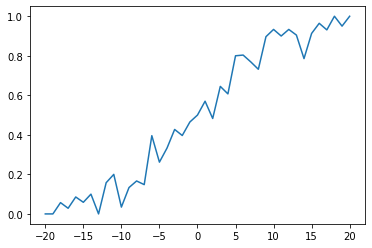

In [100]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [101]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5403558722789427
logloss of cvsplit 1: 0.5386975127265455
logloss of cvsplit 2: 0.5395527436368125


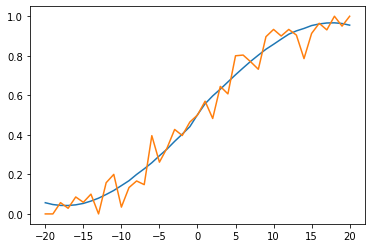

In [102]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [103]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0,1)#0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5403558722789427
adjusted logloss of cvsplit 1: 0.5386975127265455
adjusted logloss of cvsplit 2: 0.5395527436368125


In [104]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.3214389944753606
adjusted logloss of cvsplit 1: 1.3212336546859873
adjusted logloss of cvsplit 2: 1.3222839202483188


In [105]:
#looking for upsets
upsets = pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
).sort_values(by = 'Season')
upsets[upsets['T1_TeamID'] < upsets['T2_TeamID']] #.groupby('Season').count()
#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Distance,T2_Distance,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff,T1_COL,T1_DOL,T1_MOR,T1_POM,T1_RTH,T1_SAG,T1_WLK,T1_WOL,T2_COL,T2_DOL,T2_MOR,T2_POM,T2_RTH,T2_SAG,T2_WLK,T2_WOL,COL_diff,DOL_diff,MOR_diff,POM_diff,RTH_diff,SAG_diff,WLK_diff,WOL_diff,T1_NetRating,T2_NetRating,NetRating_diff,Distance_diff
1063,2003,136,1173,71,1409,84,NaN,NaN,24.482759,54.206897,7.517241,20.862069,13.482759,15.206897,13.310345,5.379310,17.586207,23.896552,56.586207,5.931034,16.241379,12.172414,11.793103,11.862069,5.827586,2.827586,6.482759,104.717904,95.392009,26.387097,57.032258,6.645161,18.322581,11.161290,14.774194,14.322581,7.580645,17.322581,23.258065,58.612903,5.612903,18.161290,12.774194,11.645161,14.419355,6.967742,2.677419,8.258065,98.652904,87.571226,1.000000,1.000000,15.621396,3.678803,4,13,-9,88.852862,88.227827,84.559424,84.727965,86.242330,85.634834,86.458023,88.227827,81.167319,78.880984,84.075015,81.634973,80.940804,81.053487,81.398593,80.718735,7.685543,9.346843,0.484409,3.092993,5.301527,4.581348,5.059430,7.509092,9.325896,11.081678,-1.755782,NaN
145,2005,137,1137,64,1242,63,NaN,NaN,21.258065,47.741935,6.612903,17.580645,9.354839,12.451613,15.774194,8.000000,18.870968,19.580645,50.290323,6.000000,18.322581,10.967742,10.451613,15.870968,7.032258,2.516129,5.129032,93.073001,85.564829,26.931034,56.482759,6.793103,18.206897,11.793103,16.586207,14.482759,6.620690,19.241379,22.103448,57.137931,6.275862,19.517241,13.000000,10.655172,14.103448,7.103448,2.827586,10.206897,101.739015,87.975419,1.000000,0.500000,0.560095,12.507507,14,3,11,76.824720,78.136107,73.040842,76.161879,74.063713,75.838453,77.251039,78.411213,93.380430,90.847465,87.153435,89.194748,91.364052,90.380569,91.364052,89.953873,-16.555710,-12.711358,-14.112593,-13.032869,-17.300339,-14.542115,-14.113013,-11.542660,7.508172,13.763596,-6.255424,NaN
1206,2005,137,1393,57,1436,60,NaN,NaN,27.969697,57.606061,4.636364,14.757576,13.818182,15.666667,13.363636,8.090909,15.939394,22.363636,57.303030,7.393939,22.696970,13.848485,14.606061,14.727273,7.000000,3.303030,10.727273,102.991322,88.355060,25.366667,57.433333,8.500000,23.600000,12.033333,15.800000,11.866667,6.733333,15.833333,22.700000,55.366667,6.166667,18.866667,9.033333,12.266667,12.600000,6.166667,2.800000,10.666667,104.517731,89.161591,0.750000,1.000000,10.523029,1.120363,4,13,-9,88.852862,89.194748,87.404062,88.531436,88.531436,88.227827,87.153435,88.852862,81.755196,83.471755,76.407839,79.465558,78.045455,82.908696,84.559424,82.773350,7.097666,5.722993,10.996224,9.065878,10.485981,5.319131,2.594010,6.079512,14.636262,15.356141,-0.719879,NaN
1267,2006,137,1234,63,1322,64,NaN,NaN,23.121212,53.636364,5.606061,16.727273,11.000000,14.909091,14.757576,6.696970,15.121212,21.484848,56.484848,6.090909,19.333333,11.181818,12.484848,14.787879,7.515152,2.969697,7.636364,92.596226,81.946181,26.620690,57.344828,6.586207,18.137931,13.068966,16.655172,15.793103,8.827586,20.896552,24.172414,55.517241,5.655172,16.482759,13.000000,13.965517,17.310345,7.379310,2.862069,6.172414,99.430807,91.329708,1.000000,1.000000,4.437990,0.530888,3,14,-11,89.194748,88.227827,88.852862,88.531436,89.194748,88.227827,88.852862,89.560373,79.465558,80.286836,75.205808,79.366411,76.824720,78.136107,78.318974,81.516122,

In [106]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5147102128044319
adjusted logloss of cvsplit 1: 0.5139771813012772
adjusted logloss of cvsplit 2: 0.5139290753485071


In [107]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5147102128044319
adjusted logloss of cvsplit 1: 0.5139771813012772
adjusted logloss of cvsplit 2: 0.5139290753485071


season
2003    0.521910
2004    0.495007
2005    0.479652
2006    0.521713
2007    0.428000
2008    0.440317
2009    0.456884
2010    0.541721
2011    0.595127
2012    0.520079
2013    0.561984
2014    0.556864
2015    0.510904
2016    0.527960
2017    0.487105
2018    0.571831
dtype: float64

# Submission time!

In [108]:
#sub = pd.read_csv('MSampleSubmissionStage2.csv')
sub = pd.read_csv('MSampleSubmissionStage1_2020.csv')

sub = sub.iloc[9112:].reset_index(drop = True)

In [109]:
sub["Season"] = 2019
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133


In [110]:
sub.shape

(2278, 5)

In [111]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019_1101_1113,0.5,2019,1101,1113,25.344828,55.241379,7.241379,18.896552,9.068966,14.62069,11.655172,8.00000,19.137931,22.482759,51.137931,5.724138,17.103448,8.827586,11.103448,15.724138,5.551724,2.965517,6.827586,102.163210,92.438059,26.593750,59.468750,7.250000,21.250000,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,1.000000,6.071008,15,11,1.000000,0.666667,4
1,2019_1101_1120,0.5,2019,1101,1120,25.344828,55.241379,7.241379,18.896552,9.068966,14.62069,11.655172,8.00000,19.137931,22.482759,51.137931,5.724138,17.103448,8.827586,11.103448,15.724138,5.551724,2.965517,6.827586,102.163210,92.438059,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,107.564168,93.527084,1.000000,28.628348,15,5,1.000000,1.000000,10
2,2019_1113_1120,0.5,2019,1113,1120,26.593750,59.468750,7.250000,21.250000,12.156250,13.59375,13.593750,6.21875,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,107.564168,93.527084,6.071008,28.628348,11,5,0.666667,1.000000,6
3,2019_1101_1124,0.5,2019,1101,1124,25.344828,55.241379,7.241379,18.896552,9.068966,14.62069,11.655172,8.00000,19.137931,22.482759,51.137931,5.724138,17.103448,8.827586,11.103448,15.724138,5.551724,2.965517,6.827586,102.163210,92.438059,25.500000,57.906250,7.937500,23.375000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,9.968750,12.843750,12.406250,5.968750,4.218750,4.468750,101.650571,95.311263,1.000000,10.137139,15,9,1.000000,0.000000,6
4,2019_1113_1124,0.5,2019,1113,1124,26.593750,59.468750,7.250000,21.250000,12.156250,13.59375,13.593750,6.21875,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,25.500000,57.906250,7.937500,23.375000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,9.968750,12.843750,12.406250,5.968750,4.218750,4.468750,101.650571,95.311263,6.071008,10.137139,11,9,0.666667,0.000000,2


In [112]:
sub.shape

(2278, 54)

# Distance Add

In [113]:
location_data

,TeamID,TeamName,CityID,City,State,lat,lng
0,1445,W Salem St,4371,Winston-Salem,NC,36.1029,80.2610
1,1448,Wake Forest,4371,Winston-Salem,NC,36.1029,80.2610
2,1147,Centenary,4315,Shreveport,LA,32.4659,93.7959
3,1210,Georgia Tech,4100,Duluth,GA,34.0053,84.1491
4,1210,Georgia Tech,4016,Atlanta,GA,33.7627,84.4225
...,...,...,...,...,...,...,...
370,1159,Colgate,4144,Hamilton,NY,42.8292,75.5503
371,1272,Memphis,4213,Memphis,TN,35.1046,89.9773
372,1436,Vermont,4051,Burlington,VT,44.4877,73.2314
373,1463,Yale,4236,New Haven,CT,41.3112,72.9246


In [114]:
tourney_game_loc = game_cities[(game_cities['CRType'] == 'NCAA') & \
                                             (game_cities['Season'] == 2019)].reset_index(drop = True)

In [115]:
tourney_game_loc

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2019,134,1125,1396,NCAA,4091
1,2019,134,1192,1341,NCAA,4091
2,2019,135,1113,1385,NCAA,4091
3,2019,135,1295,1300,NCAA,4091
4,2019,136,1120,1308,NCAA,4301
5,2019,136,1124,1393,NCAA,4301
6,2019,136,1196,1305,NCAA,4097
7,2019,136,1199,1436,NCAA,4149
8,2019,136,1211,1192,NCAA,4301
9,2019,136,1242,1318,NCAA,4301


In [116]:
tourney_game_Wloc = pd.merge(tourney_game_loc,sub, left_on = ['Season','WTeamID','LTeamID'], right_on = ['Season','T1_TeamID','T2_TeamID'], how = 'left') #.drop(['DayNum','WTeamID','LTeamID','CRType'], axis = 1)

In [117]:
tourney_game_Wloc

,Season,DayNum,WTeamID,LTeamID,CRType,CityID,ID,Pred,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019,134,1125,1396,NCAA,4091,2019_1125_1396,0.5,1125.0,1396.0,31.666667,63.733333,10.366667,27.966667,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,9.500000,12.166667,12.233333,6.200000,3.700000,12.200000,110.804003,95.242121,26.406250,60.218750,7.500000,22.687500,9.718750,14.468750,11.156250,8.656250,17.468750,25.406250,57.625000,7.187500,22.000000,10.343750,12.687500,14.875000,5.500000,2.531250,3.687500,99.808393,94.890902,5.271791,9.931409,11.0,11.0,0.500000,0.666667,0.0
1,2019,134,1192,1341,NCAA,4091,2019_1192_1341,0.5,1192.0,1341.0,26.193548,55.225806,7.806452,19.322581,9.225806,13.935484,13.451613,7.516129,16.741935,26.193548,58.290323,7.709677,22.451613,11.451613,13.483871,14.129032,6.193548,3.290323,2.258065,101.800736,98.725185,25.515152,58.606061,6.181818,19.666667,11.212121,12.303030,12.606061,8.818182,21.696970,24.606061,54.272727,6.000000,19.454545,11.333333,12.818182,17.939394,5.121212,4.303030,2.121212,97.604704,94.838579,0.335595,0.362145,16.0,16.0,1.000000,1.000000,0.0
2,2019,135,1113,1385,NCAA,4091,2019_1113_1385,0.5,1113.0,1385.0,26.593750,59.468750,7.250000,21.250000,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,27.939394,61.545455,8.515152,23.575758,7.636364,14.030303,10.363636,8.818182,19.060606,25.181818,57.939394,8.424242,24.727273,10.545455,13.636364,15.454545,5.181818,2.424242,2.727273,100.732772,97.188616,6.071008,9.297347,11.0,11.0,0.666667,0.333333,0.0
3,2019,135,1295,1300,NCAA,4091,2019_1295_1300,0.5,1295.0,1300.0,24.580645,54.709677,9.709677,26.354839,6.580645,11.322581,10.645161,4.741935,15.129032,27.387097,58.161290,7.612903,20.774194,8.258065,12.322581,9.806452,5.322581,2.741935,-1.451613,103.457554,105.535015,24.266667,54.933333,6.266667,20.100000,11.533333,14.433333,15.500000,5.266667,18.033333,24.933333,56.266667,6.033333,19.133333,9.200000,13.100000,11.966667,6.133333,3.800000,-0.166667,95.609363,95.844738,0.470129,0.088903,16.0,16.0,1.000000,0.750000,0.0
4,2019,136,1120,1308,NCAA,4301,2019_1120_1308,0.5,1120.0,1308.0,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,107.564168,93.527084,27.343750,59.281250,9.375000,27.531250,12.625000,14.500000,12.031250,5.531250,18.093750,22.718750,53.843750,6.968750,21.031250,7.125000,8.656250,13.125000,4.843750,1.875000,12.843750,110.339640,92.090308,28.628348,6.468897,5.0,12.0,1.000000,1.000000,-7.0
5,2019,136,1124,1393,NCAA,4301,2019_1124_1393,0.5,1124.0,1393.0,25.500000,57.906250,7.937500,23.375000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,9.968750,12.843750,12.406250,5.968750,4.218750,4.468750,101.650571,95.311263,23.848485,56.242424,7.939394,24.090909,10.787879,12.000000,12.454545,8.272727,17.424242,21.757576,54.757576,8.424242,26.060606,12.000000,14.727273,15.666667,6.606061,3.121212,4.030303,96.448100,90.873307,10.137139,9.980338,9.0,8.0,0.000000,0.250000,1.0
6,2019,136,1196,1305,NCAA,4097,2019_1196_1305,0.5

In [118]:
tourney_game_Lloc = pd.merge(tourney_game_loc, sub, left_on = ['Season','WTeamID','LTeamID'], right_on = ['Season','T2_TeamID','T1_TeamID'], how = 'left') #.drop(['DayNum','WTeamID','LTeamID','CRType'], axis = 1)

In [119]:
tourney_game_Lloc

,Season,DayNum,WTeamID,LTeamID,CRType,CityID,ID,Pred,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019,134,1125,1396,NCAA,4091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,134,1192,1341,NCAA,4091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,135,1113,1385,NCAA,4091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,135,1295,1300,NCAA,4091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,136,1120,1308,NCAA,4301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019,136,1124,1393,NCAA,4301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019,136,1196,1305,NCAA,4097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019,136,1199,1436,NCAA,4149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019,136,1211,1192,NCAA,4301,2019_1192_1211,0.5,1192.0,1211.0,26.193548,55.225806,7.806452,19.322581,9.225806,13.935484,13.451613,7.516129,16.741935,26.193548,58.290323,7.709677,22.451613,11.451613,13.483871,14.129032,6.193548,3.290323,2.258065,101.800736,98.725185,32.181818,60.515152,7.787879,21.333333,9.545455,18.212121,10.363636,7.545455,16.060606,23.878788,61.454545,6.575758,21.272727,10.818182,9.818182,13.545455,5.151515,1.939394,23.787879,117.321253,85.910208,0.335595,55.838844,16.0,1.0,1.000000,0.500000,15.0
9,2019,136,1242,1318,NCAA,4301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
sub = tourney_game_Lloc.fillna(tourney_game_Wloc)
sub.drop(['DayNum','WTeamID','LTeamID','CRType'], axis = 1, inplace = True)
sub.rename(columns={'CityID':'GameCityID'},inplace = True)

In [121]:
sub

,Season,GameCityID,ID,Pred,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019,4091,2019_1125_1396,0.5,1125.0,1396.0,31.666667,63.733333,10.366667,27.966667,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,9.500000,12.166667,12.233333,6.200000,3.700000,12.200000,110.804003,95.242121,26.406250,60.218750,7.500000,22.687500,9.718750,14.468750,11.156250,8.656250,17.468750,25.406250,57.625000,7.187500,22.000000,10.343750,12.687500,14.875000,5.500000,2.531250,3.687500,99.808393,94.890902,5.271791,9.931409,11.0,11.0,0.500000,0.666667,0.0
1,2019,4091,2019_1192_1341,0.5,1192.0,1341.0,26.193548,55.225806,7.806452,19.322581,9.225806,13.935484,13.451613,7.516129,16.741935,26.193548,58.290323,7.709677,22.451613,11.451613,13.483871,14.129032,6.193548,3.290323,2.258065,101.800736,98.725185,25.515152,58.606061,6.181818,19.666667,11.212121,12.303030,12.606061,8.818182,21.696970,24.606061,54.272727,6.000000,19.454545,11.333333,12.818182,17.939394,5.121212,4.303030,2.121212,97.604704,94.838579,0.335595,0.362145,16.0,16.0,1.000000,1.000000,0.0
2,2019,4091,2019_1113_1385,0.5,1113.0,1385.0,26.593750,59.468750,7.250000,21.250000,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,27.939394,61.545455,8.515152,23.575758,7.636364,14.030303,10.363636,8.818182,19.060606,25.181818,57.939394,8.424242,24.727273,10.545455,13.636364,15.454545,5.181818,2.424242,2.727273,100.732772,97.188616,6.071008,9.297347,11.0,11.0,0.666667,0.333333,0.0
3,2019,4091,2019_1295_1300,0.5,1295.0,1300.0,24.580645,54.709677,9.709677,26.354839,6.580645,11.322581,10.645161,4.741935,15.129032,27.387097,58.161290,7.612903,20.774194,8.258065,12.322581,9.806452,5.322581,2.741935,-1.451613,103.457554,105.535015,24.266667,54.933333,6.266667,20.100000,11.533333,14.433333,15.500000,5.266667,18.033333,24.933333,56.266667,6.033333,19.133333,9.200000,13.100000,11.966667,6.133333,3.800000,-0.166667,95.609363,95.844738,0.470129,0.088903,16.0,16.0,1.000000,0.750000,0.0
4,2019,4301,2019_1120_1308,0.5,1120.0,1308.0,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,107.564168,93.527084,27.343750,59.281250,9.375000,27.531250,12.625000,14.500000,12.031250,5.531250,18.093750,22.718750,53.843750,6.968750,21.031250,7.125000,8.656250,13.125000,4.843750,1.875000,12.843750,110.339640,92.090308,28.628348,6.468897,5.0,12.0,1.000000,1.000000,-7.0
5,2019,4301,2019_1124_1393,0.5,1124.0,1393.0,25.500000,57.906250,7.937500,23.375000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,9.968750,12.843750,12.406250,5.968750,4.218750,4.468750,101.650571,95.311263,23.848485,56.242424,7.939394,24.090909,10.787879,12.000000,12.454545,8.272727,17.424242,21.757576,54.757576,8.424242,26.060606,12.000000,14.727273,15.666667,6.606061,3.121212,4.030303,96.448100,90.873307,10.137139,9.980338,9.0,8.0,0.000000,0.250000,1.0
6,2019,4097,2019_1196_1305,0.5,1196.0,1305.0,23.941176,56.088235,8.147059,24.352941,10.617647,12.235294,11.764706,7.176471,17.147059,22.441176,53.058824,6.441176,20.147059,10.647059,10.9411

In [122]:
sub = pd.merge(sub, location_data.drop_duplicates(subset = 'City').drop('TeamID', axis = 1), left_on = 'GameCityID', right_on = 'CityID', how = 'left')
sub.drop(['CityID','State','TeamName','City'], axis = 1, inplace = True)
sub.rename(columns = {'lat':'GameCityLat','lng':'GameCityLng'}, inplace = True)

In [123]:
sub = pd.merge(sub, location_data.drop_duplicates(subset = 'TeamID'), left_on = 'T1_TeamID', right_on = 'TeamID', how = 'left')
sub.drop(['TeamID','CityID','State','TeamName','City'], axis = 1, inplace = True)
sub.rename(columns = {'lat':'T1_CityLat','lng':'T1_CityLng'}, inplace = True)

In [124]:
sub = pd.merge(sub, location_data.drop_duplicates(subset = 'TeamID'), left_on = 'T2_TeamID', right_on = 'TeamID', how = 'left')
sub.drop(['TeamID','CityID','State','TeamName','City'], axis = 1, inplace = True)
sub.rename(columns = {'lat':'T2_CityLat','lng':'T2_CityLng'}, inplace = True)

In [125]:
sub

,Season,GameCityID,ID,Pred,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,GameCityLat,GameCityLng,T1_CityLat,T1_CityLng,T2_CityLat,T2_CityLng
0,2019,4091,2019_1125_1396,0.5,1125.0,1396.0,31.666667,63.733333,10.366667,27.966667,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,9.500000,12.166667,12.233333,6.200000,3.700000,12.200000,110.804003,95.242121,26.406250,60.218750,7.500000,22.687500,9.718750,14.468750,11.156250,8.656250,17.468750,25.406250,57.625000,7.187500,22.000000,10.343750,12.687500,14.875000,5.500000,2.531250,3.687500,99.808393,94.890902,5.271791,9.931409,11.0,11.0,0.500000,0.666667,0.0,39.7797,84.1998,36.1715,86.7843,40.0077,75.1339
1,2019,4091,2019_1192_1341,0.5,1192.0,1341.0,26.193548,55.225806,7.806452,19.322581,9.225806,13.935484,13.451613,7.516129,16.741935,26.193548,58.290323,7.709677,22.451613,11.451613,13.483871,14.129032,6.193548,3.290323,2.258065,101.800736,98.725185,25.515152,58.606061,6.181818,19.666667,11.212121,12.303030,12.606061,8.818182,21.696970,24.606061,54.272727,6.000000,19.454545,11.333333,12.818182,17.939394,5.121212,4.303030,2.121212,97.604704,94.838579,0.335595,0.362145,16.0,16.0,1.000000,1.000000,0.0,39.7797,84.1998,40.8890,74.0461,30.0850,95.9897
2,2019,4091,2019_1113_1385,0.5,1113.0,1385.0,26.593750,59.468750,7.250000,21.250000,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,27.939394,61.545455,8.515152,23.575758,7.636364,14.030303,10.363636,8.818182,19.060606,25.181818,57.939394,8.424242,24.727273,10.545455,13.636364,15.454545,5.181818,2.424242,2.727273,100.732772,97.188616,6.071008,9.297347,11.0,11.0,0.666667,0.333333,0.0,39.7797,84.1998,33.3881,111.9318,40.7498,73.7976
3,2019,4091,2019_1295_1300,0.5,1295.0,1300.0,24.580645,54.709677,9.709677,26.354839,6.580645,11.322581,10.645161,4.741935,15.129032,27.387097,58.161290,7.612903,20.774194,8.258065,12.322581,9.806452,5.322581,2.741935,-1.451613,103.457554,105.535015,24.266667,54.933333,6.266667,20.100000,11.533333,14.433333,15.500000,5.266667,18.033333,24.933333,56.266667,6.033333,19.133333,9.200000,13.100000,11.966667,6.133333,3.800000,-0.166667,95.609363,95.844738,0.470129,0.088903,16.0,16.0,1.000000,0.750000,0.0,39.7797,84.1998,46.8653,96.8292,35.9795,78.9032
4,2019,4301,2019_1120_1308,0.5,1120.0,1308.0,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,107.564168,93.527084,27.343750,59.281250,9.375000,27.531250,12.625000,14.500000,12.031250,5.531250,18.093750,22.718750,53.843750,6.968750,21.031250,7.125000,8.656250,13.125000,4.843750,1.875000,12.843750,110.339640,92.090308,28.628348,6.468897,5.0,12.0,1.000000,1.000000,-7.0,40.7774,111.9300,32.6087,85.4899,32.3265,106.7893
5,2019,4301,2019_1124_1393,0.5,1124.0,1393.0,25.500000,57.906250,7.937500,23.375000,13.375000,13.843750,13.281250,6.125000,18.781250,23.218750,55.031250,7.093750,20.781250,9.968750,12.843750,12.406250,5.968750,4.218750,4.468750,101.650571,95.311263,23.848485,56.242424,7.939394,24.090909,10.787879,12.000000,12.454545,8.272727,17.424242,21.757576,54.757576,8.424242,26.060606,12.0

In [126]:
#geopy.distance.distance(geopy.point.Point(39.1239,94.5541),geopy.point.Point(38.0423,84.4587)).km

In [127]:
sub['GameCityLat'] = np.radians(sub['GameCityLat'])
sub['GameCityLng'] = np.radians(sub['GameCityLng'])
sub['T1_CityLat'] = np.radians(sub['T1_CityLat'])
sub['T1_CityLng'] = np.radians(sub['T1_CityLng'])
sub['T2_CityLat'] = np.radians(sub['T2_CityLat'])
sub['T2_CityLng'] = np.radians(sub['T2_CityLng'])

wdlon = sub['GameCityLng'] - sub['T1_CityLng']
wdlat = sub['GameCityLat'] - sub['T1_CityLat']
ldlon = sub['GameCityLng'] - sub['T2_CityLng']
ldlat = sub['GameCityLat'] - sub['T2_CityLat']

wtemp = 2 * np.arctan2(np.sqrt(np.sin(wdlat / 2)**2 + np.cos(sub['T1_CityLat']) * np.cos(sub['GameCityLat']) * np.sin(wdlon / 2)**2), np.sqrt(1 - np.sin(wdlat / 2)**2 + np.cos(sub['T1_CityLat']) * np.cos(sub['GameCityLat']) * np.sin(wdlon / 2)**2))
ltemp = 2 * np.arctan2(np.sqrt(np.sin(ldlat / 2)**2 + np.cos(sub['T2_CityLat']) * np.cos(sub['GameCityLat']) * np.sin(ldlon / 2)**2), np.sqrt(1 - np.sin(ldlat / 2)**2 + np.cos(sub['T2_CityLat']) * np.cos(sub['GameCityLat']) * np.sin(ldlon / 2)**2))

sub['T1_Distance'] = R * wtemp
sub['T2_Distance'] = R * ltemp

In [128]:
sub.drop(['GameCityID','GameCityLat','GameCityLng','T1_CityLat','T1_CityLng','T2_CityLat','T2_CityLng'],axis = 1, inplace = True)

In [129]:
sub['Distance_diff'] = sub['T1_Distance'] - sub['T2_Distance']

# MasRating Add

In [130]:
sub = pd.merge(sub, MasRating, left_on = ['Season', 'T1_TeamID'],right_on = ['Season','TeamID'], how = 'left')
sub = sub.drop('TeamID', axis = 1)

for x in MasRating.columns[2:]:
    sub.rename(columns={x:'T1_'+x}, inplace=True)
    
sub = pd.merge(sub, MasRating, left_on = ['Season', 'T2_TeamID'],right_on = ['Season','TeamID'], how = 'left')
sub = sub.drop('TeamID', axis = 1)

for x in MasRating.columns[2:]:
    sub.rename(columns={x:'T2_'+x}, inplace=True)

In [131]:
for x in MasRating.columns[2:]:
    sub[x+'_diff'] = sub['T1_'+x] - sub['T2_'+x]

# NetRating Add

In [132]:
sub["T2_NetRating"] = sub["T2_OffRating"] - sub["T2_opponent_OffRating"]
sub["T1_NetRating"] = sub["T1_OffRating"] - sub["T1_opponent_OffRating"]
sub["NetRating_diff"] = sub["T1_NetRating"] - sub["T2_NetRating"]


sub.head()

,Season,ID,Pred,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_OffRating,T1_opponent_OffRating,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_OffRating,T2_opponent_OffRating,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff,T1_Distance,T2_Distance,Distance_diff,T1_COL,T1_DOL,T1_MOR,T1_POM,T1_RTH,T1_SAG,T1_WLK,T1_WOL,T2_COL,T2_DOL,T2_MOR,T2_POM,T2_RTH,T2_SAG,T2_WLK,T2_WOL,COL_diff,DOL_diff,MOR_diff,POM_diff,RTH_diff,SAG_diff,WLK_diff,WOL_diff,T2_NetRating,T1_NetRating,NetRating_diff
0,2019,2019_1125_1396,0.5,1125.0,1396.0,31.666667,63.733333,10.366667,27.966667,8.900000,19.600000,11.600000,6.666667,15.700000,27.333333,63.766667,7.666667,22.133333,9.500000,12.166667,12.233333,6.200000,3.700000,12.200000,110.804003,95.242121,26.406250,60.218750,7.500000,22.687500,9.718750,14.468750,11.156250,8.656250,17.468750,25.406250,57.625000,7.187500,22.000000,10.343750,12.687500,14.875000,5.500000,2.531250,3.687500,99.808393,94.890902,5.271791,9.931409,11.0,11.0,0.500000,0.666667,0.0,460.694123,770.928227,-310.234104,82.250901,82.124635,82.639980,81.516122,79.869655,80.829232,81.516122,84.075015,84.233153,81.999970,79.869655,79.170233,81.876843,79.972665,80.500831,83.471755,-1.982253,0.124665,2.770324,2.345889,-2.007188,0.856567,1.015291,0.603260,4.917491,15.561882,10.644392
1,2019,2019_1192_1341,0.5,1192.0,1341.0,26.193548,55.225806,7.806452,19.322581,9.225806,13.935484,13.451613,7.516129,16.741935,26.193548,58.290323,7.709677,22.451613,11.451613,13.483871,14.129032,6.193548,3.290323,2.258065,101.800736,98.725185,25.515152,58.606061,6.181818,19.666667,11.212121,12.303030,12.606061,8.818182,21.696970,24.606061,54.272727,6.000000,19.454545,11.333333,12.818182,17.939394,5.121212,4.303030,2.121212,97.604704,94.838579,0.335595,0.362145,16.0,16.0,1.000000,1.000000,0.0,865.268461,1509.444635,-644.176174,70.023905,68.726159,73.694076,69.176118,68.090587,68.598383,69.761276,69.958094,70.822075,70.754940,68.217052,69.111570,67.838592,67.775784,70.023905,71.913235,-0.798170,-2.028781,5.477024,0.064548,0.251995,0.822600,-0.262629,-1.955141,2.766125,3.075551,0.309426
2,2019,2019_1113_1385,0.5,1113.0,1385.0,26.593750,59.468750,7.250000,21.250000,12.156250,13.593750,13.593750,6.218750,19.906250,24.218750,58.687500,8.562500,25.500000,10.000000,13.281250,13.906250,6.343750,3.468750,4.750000,101.291885,95.108606,27.939394,61.545455,8.515152,23.575758,7.636364,14.030303,10.363636,8.818182,19.060606,25.181818,57.939394,8.424242,24.727273,10.545455,13.636364,15.454545,5.181818,2.424242,2.727273,100.732772,97.188616,6.071008,9.297347,11.0,11.0,0.666667,0.333333,0.0,2474.472256,884.697407,1589.774849,83.185685,81.516122,81.282340,80.718735,81.634973,81.755196,81.398593,81.282340,82.124635,81.398593,78.785840,78.976754,82.250901,80.181230,80.076515,81.167319,1.061050,0.117529,2.496501,1.741981,-0.615928,1.573966,1.322079,0.115022,3.544155,6.183280,2.639124
3,2019,2019_1295_1300,0.5,1295.0,1300.0,24.580645,54.709677,9.709677,26.354839,6.580645,11.322581,10.645161,4.741935,15.129032,27.387097,58.161290,7.612903,20.774194,8.258065,12.322581,9.806452,5.322581,2.741935,-1.451613,103.457554,105.535015,24.266667,54.933333,6.266667,20.100000,11.533333,14.433333,15.500000,5.266667,18.033333,24.933333,56.266667,6.033333,19.133333,9.200000,13.100000,11.966667,6.133333,3.800000,-0.166667,95.609363,95.844738,0.470129,0.088903,16.0,16.0,1.000000,0.750000,0.0,1279.766496,627.358258,652.408238,70.288200,70.288200,67.713051,69.761276,69

In [133]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [134]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [135]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
#sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("paris-submission.csv", index = None)

In [136]:
solution = pd.read_csv('MDataFiles_Stage1/MNCAATourneyCompactResults.csv')

In [137]:
solution = solution[solution['Season']==2019].reset_index(drop=True)

In [138]:
solution['SmallerID'] = solution[['WTeamID','LTeamID']].min(axis=1)
solution['BiggerID'] = solution[['WTeamID','LTeamID']].max(axis=1)

In [139]:
solution['SmallerID'] = solution['SmallerID'].astype('str', copy=False)
solution['BiggerID'] = solution['BiggerID'].astype('str', copy=False)

In [140]:
solution['ID'] = '2019_' + solution['SmallerID'] + '_' + solution['BiggerID']

In [141]:
solution['SmallerID'] = solution['SmallerID'].astype('int64', copy=False)
solution['BiggerID'] = solution['BiggerID'].astype('int64', copy=False)

In [142]:
solution = solution.sort_values(by=['ID']).reset_index(drop=True)

In [143]:
solution.loc[solution['WTeamID'] == solution['SmallerID'] , 'Pred'] = 1
solution.loc[solution['LTeamID'] == solution['SmallerID'] , 'Pred'] = 0

#solution[solution['LTeamID'] == solution['SmallerID']]

In [144]:
solution = solution[['ID','Pred']]

In [145]:
pd.set_option('display.max_rows',10)
solution

,ID,Pred
0,2019_1101_1246,0.0
1,2019_1113_1138,0.0
2,2019_1113_1385,1.0
3,2019_1120_1242,1.0
4,2019_1120_1246,1.0
...,...,...
62,2019_1387_1439,0.0
63,2019_1388_1437,0.0
64,2019_1403_1438,0.0
65,2019_1416_1433,1.0


In [146]:
tourney_results2019 = solution
tourney_results2019 = tourney_results2019[tourney_results2019.Pred!=-1].reset_index(drop=True)
tourney_results2019.columns = ['ID', 'label']
tourney_results2019 = pd.merge(tourney_results2019, sub, on = 'ID')
log_loss(tourney_results2019.label, tourney_results2019.Pred)

0.45233361102425285

In [147]:
0.45233361102425285 #netR for every team, seed_diff, marginal 'POM_diff'/'WLK_diff'/'SAG_diff', ["T1_quality","T2_quality"] + distances and distance diff
0.4587598460617547 #netR for every team, seed_diff, marginal 'POM_diff'/'WLK_diff'/'SAG_diff', ["T1_quality","T2_quality"] 
0.466590184362132 #netR for every team, seed_diff, marginal 'POM_diff'/'WLK_diff'/'SAG_diff'
0.47079403911866224 #netR for every team, seed_diff,'POM_diff'/'WLK_diff'/'SAG_diff'
0.4725414592244727 #netR for every team, seed_diff, POM_diff / Sag_diff
0.4758129667666522 #netR for every team, seed_diff,all massey
0.4764853673520888 #netR for every team, seed_diff 'POM_diff','WLK_diff','SAG_diff','DOL_diff'
0.47870392115293825 #netR for every team, seed_diff,POM_diff
0.4799164519716701 #netR for every team, seed_diff,all massey diffs
0.4818785097855526 #netR for every team, seed_diff 'POM_diff','WLK_diff','SAG_diff','MOR_diff'

0.4818785097855526

In [148]:
# to add: SImmons, Dokter Entropy, Massey and Kirkpatrick | distance? | strength of schedule 